## Hardware Testbed and Large-scale Testbed Co-simulation

## Co-Simulation

In [1]:
# --- imports ---

import os
import subprocess

import time
import logging
logger = logging.getLogger(__name__)

import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

import andes
andes.config_logger(30)
print(andes.__version__)

%matplotlib inline

# --- set logging level ---
# logger.setLevel(logging.WARNING)
from core_io import data_read, data_write, io_config, cs_stat, cs_config

0.post4599+g7310539


In [2]:

is_test = True
rflie = 'datar.txt'
wfile = 'dataw.txt'
if is_test:
    rflie = 't' + rflie

# --- set path ---
path_proj = os.getcwd()
path_case = os.path.join(path_proj, 'case')
path_data = os.path.join(path_proj, 'data')
path_ltb = os.path.join(path_proj, 'core_ltb.py')
filer = os.path.join(path_data, rflie)
filew = os.path.join(path_data, wfile)
path_ehtb = os.path.join(path_data, 'ehtb.py')
path_out = os.path.join(path_proj, 'output')

case1 = os.path.join(path_case, 'ieee14_htb.xlsx')
case2 = os.path.join(path_case, 'pjm5_htb.xlsx')
case3 = os.path.join(path_case, 'npcc_htb.xlsx')
case4 = os.path.join(path_case, 'ieee39_htb.xlsx')

In [3]:
ss = andes.load(case4,
                no_output=True,
                default_config=True,
                setup=False)

In [4]:
#  --- HTB variables ---
pq_htb = 'PQ_8'  # load represents for HTB
bus_htb = ss.PQ.get(idx=pq_htb, src='bus', attr='v')  # get bus index of HTB
bus_slack = ss.Slack.bus.v[0]  # get bus index of slack bus

AGC_control = 1  # 1: AGC control, 0: no AGC control

p_inj = 3

# --- AGC settings ---
intv_agc = 4  # interval of AGC

tgov_idx = 'TGOV1_1'  # TurbineGov idx

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.005  # 0.05
Ki = 0.001

# --- add Bus Freq. Measurement to HTB bus ---
ss.add('BusFreq', {'idx': 'BusFreq_HTB',
                   'name': 'BusFreq_HTB',
                   'bus': bus_htb,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})
ss.add('BusFreq', {'idx': 'BusFreq_Slack',
                   'name': 'BusFreq_Slack',
                   'bus': bus_slack,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})

ss.add('PQ', {'idx': 'PQ_HTB',
            'u':0,
            'name': 'PQ_HTB',
            'bus': bus_htb,
            'p0': p_inj,
            'q0': 0,
            'vmax': 1.2,
            'vmin': 0.8,
            'owner': 1})
# Add a Toggle that connects `PQ_HTB` at t=1 s
ss.add("Toggle", dict(model='StaticLoad', dev="PQ_HTB", t=1.0))

ss.setup()

# --- system initial conditions ---
a0 = ss.Bus.get(idx=bus_slack, src='a', attr='v')  # initial slack bus angle
p0 = ss.PQ.get(idx=pq_htb, src='p0', attr='v')  # initial HTB bus active power
q0 = ss.PQ.get(idx=pq_htb, src='q0', attr='v')  # initial HTB bus reactive power

tgov_idx = 'TGOV1_1'  # TurbineGov idx

ss.TDS.config.no_tqdm = 1  # turn off tqdm progress bar
ss.TDS.config.criteria = 0  # turn off stability criteria

# set constant power load
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()

True

In [5]:
for end_time in tqdm(np.arange(0, 100, 0.05)):  # t_total
    # --- interval AGC ---
    if end_time % intv_agc == 0:
        ss.TurbineGov.set(src='paux0', idx=tgov_idx, attr='v', value=AGC_control * ACE_raw)

    # run TDS
    if end_time == 0:
        continue
    else:
        # run TDS
        ss.TDS.config.tf = end_time
        ss.TDS.run()

        # update AGC PI Controller
        ACE_integral = ACE_integral + ss.ACEc.ace.v.sum()
        ACE_raw = -(Kp*ss.ACEc.ace.v.sum() + Ki*ACE_integral)

    if ss.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ss.exit_code}, end at {end_time}s.")


  0%|          | 0/2000 [00:00<?, ?it/s]GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_10 | 0.980  | 1    


GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


  2%|▏         | 48/2000 [00:00<00:10, 191.76it/s]

<Toggle Toggle_2>: StaticLoad.PQ_HTB status changed to 1 at t=1.0 sec.


100%|██████████| 2000/2000 [00:29<00:00, 67.91it/s]


(<Figure size 1600x600 with 2 Axes>,
 <AxesSubplot:xlabel='Time [s]', ylabel='Frequency [Hz]'>)

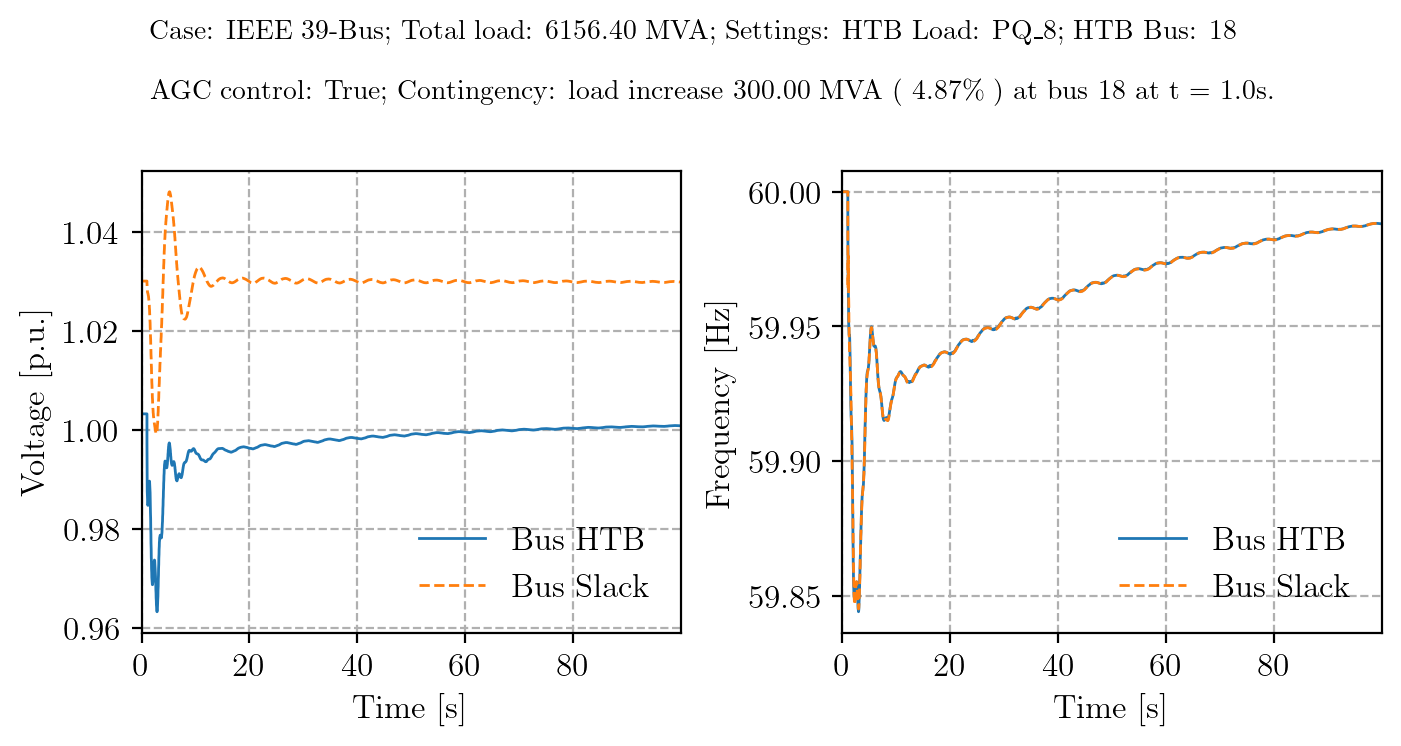

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
plt.subplots_adjust(wspace=0.3)

msg = f'Case: IEEE 39-Bus; Total load: {ss.config.mva * ss.PQ.p0.v.sum():.2f} MVA'
msg2 = f'Settings: HTB Load: {pq_htb}; HTB Bus: {bus_htb}'
msg3 = f'AGC control: {bool(AGC_control)}; Contingency: load increase {ss.config.mva * p_inj: .2f} MVA ({100 * p_inj / ss.PQ.p0.v.sum(): .2f}\% ) '
msg4 = f'at bus {ss.PQ.bus.v[-1]} at t = {ss.Toggle.t.v[-1]}s.'

fig.text(0.13, 1.1, msg + '; ' + msg2, fontsize=10)
fig.text(0.13, 1.0, msg3 + msg4, fontsize=10)

ss.TDS.plt.plot(ss.Bus.v, a=(19, 38,),
                ax=ax[0], fig=fig,
                legend=True, show=False, grid=True,
                yheader=['Bus HTB', 'Bus Slack'],
                # title='Bus voltage',
                ylabel='Voltage [p.u.]')

ss.TDS.plt.plot(ss.BusFreq.f, a=(0, 1,),
                ax=ax[1], fig=fig,
                legend=True, show=False, grid=True,
                yheader=['Bus HTB', 'Bus Slack'],
                ytimes=ss.config.freq,
                # title='Bus frequency',
                ylabel='Frequency [Hz]')
